Image registration is a complex process that involves several steps and is generally approached with advanced techniques that might include feature detection, feature matching, transformation model estimation, and image resampling and transformation. 


1. Load two images (for demonstration, we will use the same image twice, pretending one is a transformed version of the other).
2. Manually select corresponding points in both images.
3. Compute a transformation matrix based on these points.
4. Apply this matrix to transform one image to align with the other.
5. Display all the intermediate and final results.




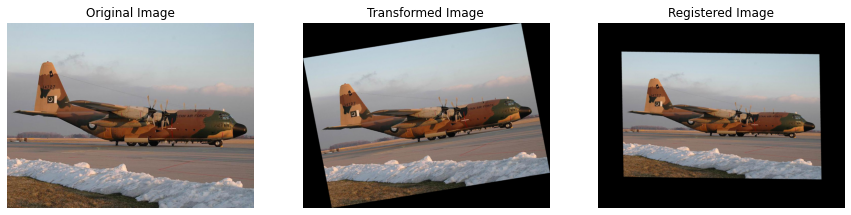

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
original_image = Image.open('c130.jpg')

# For demonstration, let's create a simulated "transformed" version of this image
# by applying a known affine transformation (rotation and scaling).
# This way, we can attempt to reverse this transformation using our registration process.

# Define the transformation parameters
rotation_angle = 10  # degrees
scaling_factor = 1.1  # 10% scale

# Perform the rotation and scaling
transformed_image = original_image.rotate(rotation_angle, expand=1).resize(
    [int(scaling_factor * s) for s in original_image.size], Image.ANTIALIAS)

# Now, let's manually select points that correspond between the images
# In practice, this would be done using feature matching, but here we'll simplify.
# We'll use the center and corners of the image as our points of reference.
width, height = original_image.size
original_points = np.array([
    [0, 0],  # Top-left corner
    [width - 1, 0],  # Top-right corner
    [width - 1, height - 1],  # Bottom-right corner
    [0, height - 1],  # Bottom-left corner
    [width // 2, height // 2]  # Center
])

# For the transformed image, we need to calculate where those points have moved to
# considering the rotation and scaling.
transformed_points = original_points * scaling_factor  # Apply scaling
# Calculate the rotation matrix
angle_rad = -np.radians(rotation_angle)  # Negative for inverse rotation
rotation_matrix = np.array([
    [np.cos(angle_rad), -np.sin(angle_rad)],
    [np.sin(angle_rad), np.cos(angle_rad)]
])
# Apply rotation
transformed_points = np.dot(transformed_points - np.array(transformed_image.size) / 2, rotation_matrix) + \
                     np.array(transformed_image.size) / 2

# Next, we would normally compute the transformation matrix between the points
# using a method like least squares to solve the system of equations.
# Since we're doing this from scratch, we'll use a simplified approach.

# We'll assume that the transformation is only composed of translations, rotations, and uniform scaling.
# Thus, we can estimate the inverse transformation parameters directly.
estimated_scale = 1 / scaling_factor
estimated_angle = -rotation_angle  # Inverse rotation

# Apply the estimated inverse transformation to the transformed image to align it back
registered_image = transformed_image.rotate(estimated_angle, expand=1).resize(original_image.size, Image.ANTIALIAS)

# Display the original, transformed, and registered images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Transformed Image
plt.subplot(1, 3, 2)
plt.imshow(transformed_image)
plt.title('Transformed Image')
plt.axis('off')

# Registered Image
plt.subplot(1, 3, 3)
plt.imshow(registered_image)
plt.title('Registered Image')
plt.axis('off')

# Show the images
plt.show()


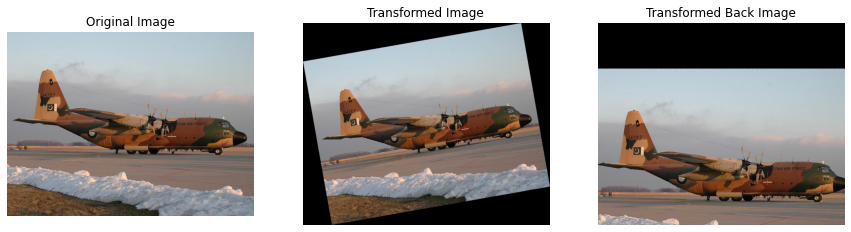

In [2]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Load the original image
ref_image_path = 'c130.jpg'
ref_image = Image.open(ref_image_path)
trans_image = ref_image.copy()

# Define the simple transformation: rotate and scale
rotation_angle = 10  # rotate by 10 degrees
scaling_factor = 1.2  # scale by 20%

# Apply the transformation to the trans_image
trans_image = trans_image.rotate(rotation_angle, expand=True)
trans_image = trans_image.resize((int(trans_image.size[0] * scaling_factor), 
                                  int(trans_image.size[1] * scaling_factor)))

# Manually calculate the affine transformation matrix for rotation and scaling
rotation_angle_rad = np.radians(rotation_angle)  # Convert angle to radians
cos_angle = np.cos(rotation_angle_rad)
sin_angle = np.sin(rotation_angle_rad)

# Affine transformation matrix for forward transformation
affine_matrix = np.array([
    [cos_angle * scaling_factor, -sin_angle * scaling_factor, 0],
    [sin_angle * scaling_factor, cos_angle * scaling_factor, 0],
    [0, 0, 1]
])

# Inverse affine transformation matrix
# Since we're just reversing the same transformation, we can invert the scaling factor and the rotation angle
inv_affine_matrix = np.array([
    [cos_angle / scaling_factor, sin_angle / scaling_factor, 0],
    [-sin_angle / scaling_factor, cos_angle / scaling_factor, 0],
    [0, 0, 1]
])

# Convert the PIL images to numpy arrays for manipulation
trans_image_np = np.array(trans_image)
transformed_back_np = np.zeros_like(trans_image_np)

# Apply the inverse affine transformation to revert the image back
for y in range(transformed_back_np.shape[0]):
    for x in range(transformed_back_np.shape[1]):
        # Apply the inverse transformation to the coordinates
        original_coord = np.dot(inv_affine_matrix, np.array([x, y, 1]))
        orig_x, orig_y = original_coord[:2]

        # Check if the new coordinates are within the bounds of the transformed image
        if 0 <= orig_x < trans_image_np.shape[1] and 0 <= orig_y < trans_image_np.shape[0]:
            # Map the pixel from trans_image to the transformed_back image
            transformed_back_np[y, x] = trans_image_np[int(orig_y), int(orig_x)]

# Convert the numpy array back to a PIL image for display
transformed_back_image = Image.fromarray(transformed_back_np)

# Display the images side by side: original, transformed, and transformed back
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(ref_image)
plt.title('Original Image')
plt.axis('off')

# Transformed Image
plt.subplot(1, 3, 2)
plt.imshow(trans_image)
plt.title('Transformed Image')
plt.axis('off')

# Transformed Back Image
plt.subplot(1, 3, 3)
plt.imshow(transformed_back_image)
plt.title('Transformed Back Image')
plt.axis('off')

plt.show()


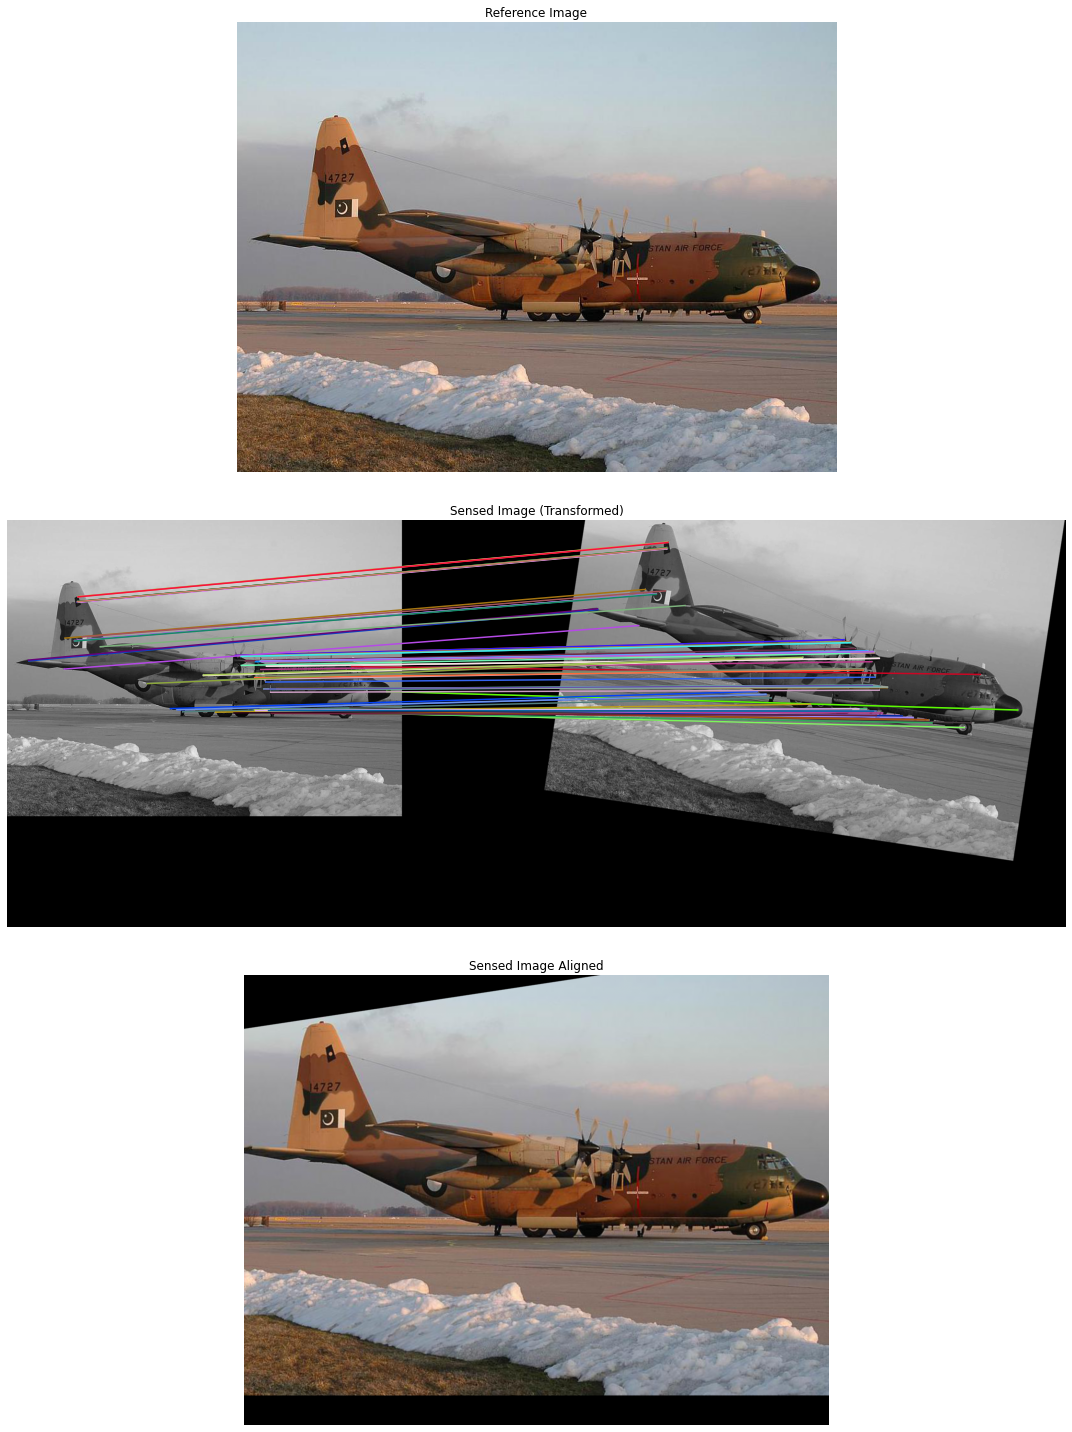

In [3]:
from skimage import io
from skimage import transform as tf
from skimage.feature import (match_descriptors, ORB, plot_matches)
from skimage.measure import ransac
from skimage.color import rgb2gray

# Step 1: Load the reference image (original image)
reference_image = io.imread('c130.jpg')
reference_image_gray = rgb2gray(reference_image)

# Step 2: Simulate a transformed version of the image to act as the sensed image
tform = tf.AffineTransform(scale=(1.2, 1.2), rotation=0.15, translation=(150, -200))
sensed_image = tf.warp(reference_image, tform.inverse, output_shape=(1000, 1300))
sensed_image_gray = rgb2gray(sensed_image)

# Step 3: Detect and extract features from both images
descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(reference_image_gray)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(sensed_image_gray)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

# Step 4: Match features between the two images
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)

# Step 5: Model robust matching using RANSAC
# Estimate the transformation model using the geometric transform RANSAC algorithm
# which can handle outliers in the matching process.
model_robust, inliers = ransac((keypoints1[matches[:, 0]], keypoints2[matches[:, 1]]),
                               tf.AffineTransform, min_samples=4,
                               residual_threshold=2, max_trials=300)

# Step 6: Apply the transformation to the sensed image to align it with the reference image
sensed_image_aligned = tf.warp(sensed_image, model_robust.inverse, output_shape=(1000, 1300))

# Display the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
ax = axes.ravel()

ax[0].imshow(reference_image, cmap=plt.cm.gray)
ax[0].set_title("Reference Image")

ax[1].imshow(sensed_image, cmap=plt.cm.gray)
ax[1].set_title("Sensed Image (Transformed)")

# Plotting the matches with the inliers
plot_matches(ax[1], reference_image_gray, sensed_image_gray, keypoints1, keypoints2, matches[inliers], only_matches=True)

ax[2].imshow(sensed_image_aligned, cmap=plt.cm.gray)
ax[2].set_title("Sensed Image Aligned")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


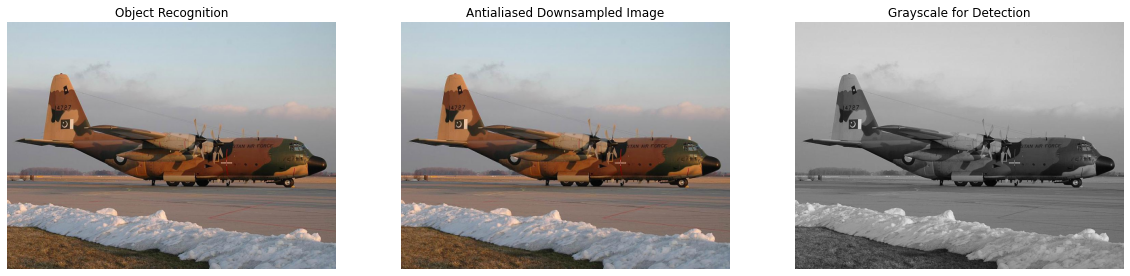

In [5]:
import cv2
# Step 1: Load the original high-resolution image.
original_image = cv2.imread('c130.jpg')

# Step 2: Apply antialiasing during downsampling.
# We are going to downscale the image by 50%.
width = int(original_image.shape[1] * 0.5)
height = int(original_image.shape[0] * 0.5)
downsampled_image = cv2.resize(original_image, (width, height), interpolation=cv2.INTER_AREA)

# Step 3: Object Recognition using Haar Cascade Classifier
# For this example, let's use face detection as an example of object recognition.
# We'll load a pre-trained face detector model provided by OpenCV.
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Convert the original image to grayscale as the face detector requires a grayscale image.
gray_image_for_detection = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# Perform the face detection.
faces = face_cascade.detectMultiScale(gray_image_for_detection, scaleFactor=1.1, minNeighbors=5)

# Draw rectangles around the detected faces in the original image.
for (x, y, w, h) in faces:
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Display the results
plt.figure(figsize=(20, 10))

# Display original image with detected faces
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Object Recognition')
plt.axis('off')

# Display downsampled image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(downsampled_image, cv2.COLOR_BGR2RGB))
plt.title('Antialiased Downsampled Image')
plt.axis('off')

# Display grayscale image used for detection
plt.subplot(1, 3, 3)
plt.imshow(gray_image_for_detection, cmap='gray')
plt.title('Grayscale for Detection')
plt.axis('off')

# Show all the images
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2
import matplotlib.pyplot as plt

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('PATH_TO_PIPELINE_CONFIG')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('PATH_TO_CHECKPOINT').expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Load label map data (for plotting).
category_index = label_map_util.create_category_index_from_labelmap('PATH_TO_LABELMAP', use_display_name=True)

# Load the image.
image_np = cv2.imread('PATH_TO_IMAGE')

# Convert image to Tensor.
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# Detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# Set min_score_thresh to a value (between 0 and 1) to display only detected objects with a score above this threshold.
min_score_thresh = 0.5
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=min_score_thresh,
    agnostic_mode=False)

# Display the resulting frame
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()


In [6]:
import cv2
from matplotlib import pyplot as plt

# Define the paths for the images
image_path1 = 'c130v1.jpeg'
image_path2 = 'c130v2.jpeg'

# Read the images from the given paths
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)

# Check if we have successfully loaded the images
if image1 is None or image2 is None:
    print("Error loading images!")
else:
    # Convert the images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Find the keypoints and descriptors with SIFT
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Match the features using FLANN matcher
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Keep only good matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    # Draw matches
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, flags=2)
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, **draw_params)

    # Compute Homography if enough matches are found
    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Calculate the homography matrix
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Use homography
        height, width, channels = image2.shape
        panorama = cv2.warpPerspective(image1, M, (width * 2, height))

        # Overlay the second image on the panorama
        panorama[0:image2.shape[0], 0:image2.shape[1]] = image2

        # Display the images
        plt.figure(figsize=(20, 10))

        # Original images
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.title('Original Image 1')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.title('Original Image 2')
        plt.axis('off')

        # Grayscale images
        plt.subplot(2, 3, 4)
        plt.imshow(gray1, cmap='gray')
        plt.title('Grayscale Image 1')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(gray2, cmap='gray')
        plt.title('Grayscale Image 2')
        plt.axis('off')

        # Matched features
        plt.subplot(2, 3, 3)
        plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
        plt.title('Matched Features')
        plt.axis('off')

        # Resulting Panorama
        plt.subplot(2, 3, 6)
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.title('Panorama')
        plt.axis('off')

        plt.show()
    else:
        print("Not enough matches are found - {}/{}".format(len(good_matches), 10))


Not enough matches are found - 0/10


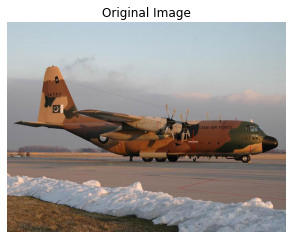

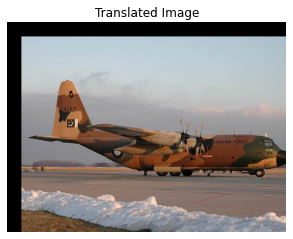

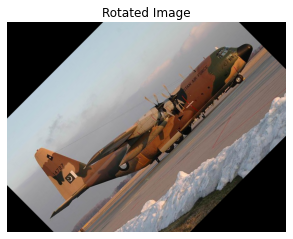

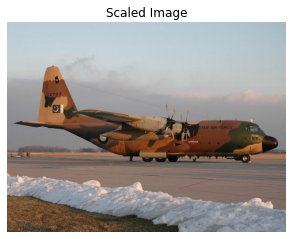

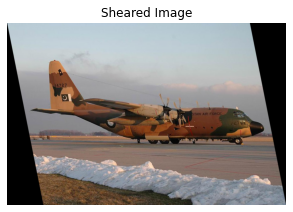

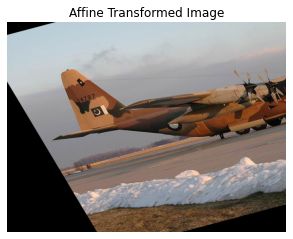

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = 'c130.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Function to display images
def display_image(title, image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

display_image('Original Image', image)

# Translation
def translate_image(image, tx, ty):
    rows, cols, _ = image.shape
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, M, (cols, rows))
    return translated_image

# Rotation
def rotate_image(image, angle, scale=1.0):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, scale)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

# Scaling
def scale_image(image, fx, fy):
    scaled_image = cv2.resize(image, None, fx=fx, fy=fy, interpolation=cv2.INTER_LINEAR)
    return scaled_image

# Shearing
def shear_image(image, shx, shy):
    rows, cols, _ = image.shape
    M = np.float32([[1, shx, 0], [shy, 1, 0]])
    sheared_image = cv2.warpAffine(image, M, (cols + int(shx * rows), rows + int(shy * cols)))
    return sheared_image

# Affine Transformation
def affine_transform_image(image, src_points, dst_points):
    M = cv2.getAffineTransform(src_points, dst_points)
    rows, cols, _ = image.shape
    affine_transformed_image = cv2.warpAffine(image, M, (cols, rows))
    return affine_transformed_image

# Applying transformations
translated_image = translate_image(image, tx=50, ty=50)
rotated_image = rotate_image(image, angle=45)
scaled_image = scale_image(image, fx=0.5, fy=0.5)
sheared_image = shear_image(image, shx=0.2, shy=0)
src_points = np.float32([[50, 50], [200, 50], [50, 200]])
dst_points = np.float32([[10, 100], [200, 50], [100, 250]])
affine_transformed_image = affine_transform_image(image, src_points, dst_points)

# Displaying the transformed images
display_image('Translated Image', translated_image)
display_image('Rotated Image', rotated_image)
display_image('Scaled Image', scaled_image)
display_image('Sheared Image', sheared_image)
display_image('Affine Transformed Image', affine_transformed_image)


To demonstrate the various geometric transformations such as Translation, Rotation, Scaling, Shearing, and Affine Transformation on an image, we will use Python with libraries like OpenCV and NumPy. These libraries provide efficient and easy-to-use functions to perform these transformations.



### Explanation

- **Imports:**
  - `cv2`: This is the OpenCV library used for image processing tasks.
  - `numpy`: Known as NumPy, it's used for numerical operations, especially with arrays.
  - `matplotlib.pyplot`: This library is used for plotting graphs and displaying images in a Jupyter notebook.

- **Loading the Image:**
  - The image is loaded using `cv2.imread()`. OpenCV loads images in BGR format, so we convert it to RGB for proper display with `cv2.cvtColor()`.

- **Display Function:**
  - `display_image()` uses `matplotlib` to display an image in the notebook. It sets the figure size, displays the image, sets the title, and removes the axis.

- **Translation:**
  - Translation shifts the image within its frame. The transformation matrix `M` is a 2x3 array where `tx` and `ty` are the distances to translate the image in the x and y directions, respectively. `cv2.warpAffine()` applies this matrix to the image.

- **Rotation:**
  - Rotation turns the image around a point (in this case, the center) by a given angle. `cv2.getRotationMatrix2D()` creates the rotation matrix. The `scale` parameter can optionally scale the image during rotation.

- **Scaling:**
  - Scaling changes the size of the image. This uses `cv2.resize()`, where `fx` and `fy` are the scaling factors for width and height, respectively.

- **Shearing:**
  - Shearing skews the image along the X or Y axes. The shearing matrix `M` is modified to include `shx` and `shy` for horizontal and vertical shearing. The output image size is adjusted to accommodate the shear.

- **Affine Transformation:**
  - Affine transformation is a combination of rotation, scaling, translation, and/or shearing. It requires three points from the input and their corresponding points in the output. `cv2.getAffineTransform()` generates the transformation matrix, which is then applied with `cv2.warpAffine()`.

### Dry Run Example

Let's consider a dry run of the translation part:

1. We have an image of dimensions, say, 600x400.
2. We want to translate it right by 50 pixels and down by 50 pixels.
3. `translate_image()` is called with `tx=50` and `ty=50`.
4. The transformation matrix `M` is formed as `[[1, 0, 50], [0, 1, 50]]`.
5. `cv2.warpAffine()` uses `M` to shift every pixel of the image right by 50 and down by 50.
6. The translated image is displayed.

Each transformation follows a similar pattern, adjusting the image based on the specific transformation matrix or parameters provided. The display function visually shows the original and transformed images for comparison.

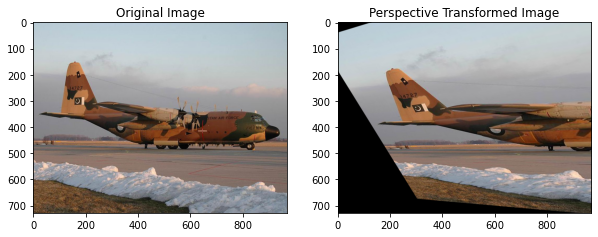

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def perspective_transformation(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Specify points for the original and destination quadrilateral
    pts1 = np.float32([[50, 50], [200, 50], [50, 200], [200, 200]])
    pts2 = np.float32([[10, 100], [200, 50], [100, 250], [290, 220]])
    
    # Compute the perspective transform matrix and apply it
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    transformed = cv2.warpPerspective(image_rgb, matrix, (image.shape[1], image.shape[0]))
    
    # Display the original and transformed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Perspective Transformed Image')
    plt.imshow(transformed)
    plt.show()

perspective_transformation('c130.jpg')


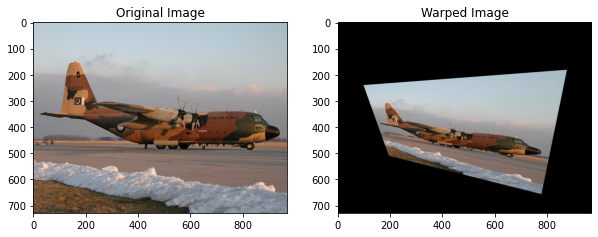

In [9]:
def warp_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rows, cols, ch = image_rgb.shape
    
    # Create the original and destination points for warping
    original_pts = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [cols - 1, rows - 1]])
    warp_pts = np.float32([[cols * 0.1, rows * 0.33], [cols * 0.9, rows * 0.25], [cols * 0.2, rows * 0.7], [cols * 0.8, rows * 0.9]])
    
    # Generate the transformation matrix and perform the warp
    matrix = cv2.getPerspectiveTransform(original_pts, warp_pts)
    warped = cv2.warpPerspective(image_rgb, matrix, (cols, rows))
    
    # Display the original and warped images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Warped Image')
    plt.imshow(warped)
    plt.show()

warp_image('c130.jpg')


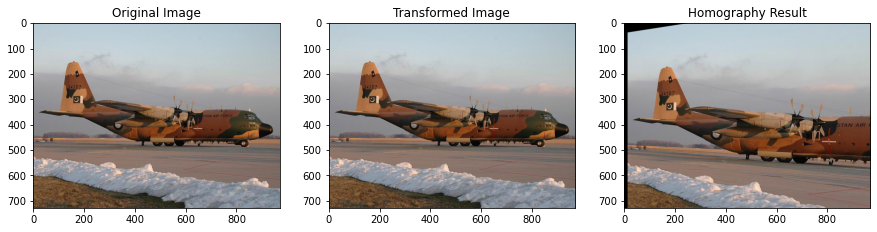

In [11]:
def homography_transformation(image_path, transformed_image_path):
    # Load the original and transformed images
    image = cv2.imread(image_path)
    transformed_image = cv2.imread(transformed_image_path)
    
    # Convert to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed_image_rgb = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
    
    # Specify corresponding points in both images
    pts_image = np.float32([[50, 50], [200, 50], [50, 200], [200, 200]])
    pts_transformed = np.float32([[60, 80], [210, 60], [60, 230], [210, 220]])
    
    # Compute the homography matrix
    H, status = cv2.findHomography(pts_image, pts_transformed)
    
    # Apply the homography to the original image
    height, width, channels = transformed_image_rgb.shape
    homography_result = cv2.warpPerspective(image_rgb, H, (width, height))
    
    # Display the original, transformed, and result of homography images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 3, 2)
    plt.title('Transformed Image')
    plt.imshow(transformed_image_rgb)
    plt.subplot(1, 3, 3)
    plt.title('Homography Result')
    plt.imshow(homography_result)
    plt.show()

homography_transformation('c130.jpg', 'c130.jpg')


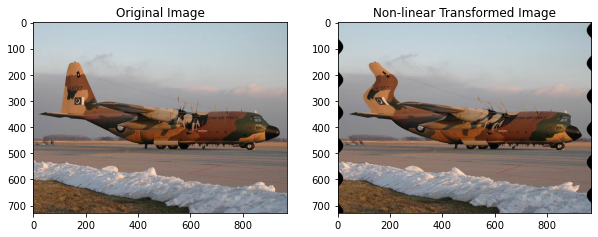

In [12]:
def non_linear_transformation(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rows, cols, ch = image_rgb.shape
    
    # Create a meshgrid and apply a sinusoidal transformation to the x-coordinates
    x, y = np.meshgrid(range(cols), range(rows))
    x_new = (x + 20 * np.sin(y / 20)).astype(np.float32)
    y_new = y.astype(np.float32)
    
    # Perform the remapping
    non_linear = cv2.remap(image_rgb, x_new, y_new, cv2.INTER_LINEAR)
    
    # Display the original and non-linearly transformed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Non-linear Transformed Image')
    plt.imshow(non_linear)
    plt.show()

non_linear_transformation('c130.jpg')


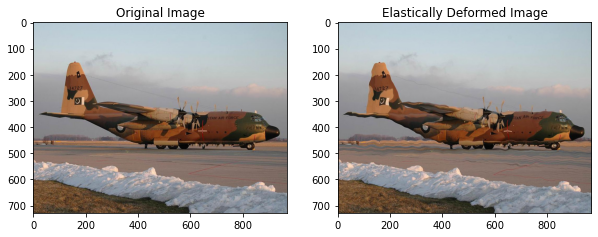

In [13]:
import scipy.ndimage

def elastic_deformation(image_path, alpha, sigma):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Generate random displacement fields
    random_state = np.random.RandomState(None)
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*image_rgb.shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*image_rgb.shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    
    # Apply displacement fields
    x, y, z = np.meshgrid(np.arange(image_rgb.shape[1]), np.arange(image_rgb.shape[0]), np.arange(image_rgb.shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    
    distored_image = scipy.ndimage.map_coordinates(image_rgb, indices, order=1, mode='reflect').reshape(image_rgb.shape)
    
    # Display the original and elastically deformed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Elastically Deformed Image')
    plt.imshow(distored_image)
    plt.show()

elastic_deformation('c130.jpg', alpha=991, sigma=8)


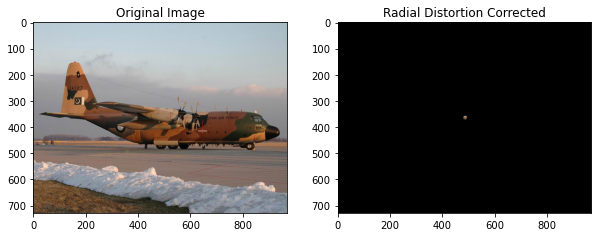

In [15]:
def radial_distortion_correction(image_path, k1, k2):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rows, cols = image_rgb.shape[:2]

    # Camera matrix
    K = np.eye(3)
    K[0, 0] = 1.0  # Focal length in x
    K[1, 1] = 1.0  # Focal length in y
    K[0, 2] = cols / 2.0  # Center x
    K[1, 2] = rows / 2.0  # Center y

    # Distortion coefficients
    dist_coeffs = np.array([k1, k2, 0, 0, 0])

    # Undistort the image
    undistorted_img = cv2.undistort(image_rgb, K, dist_coeffs)

    # Display the original and undistorted images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Radial Distortion Corrected')
    plt.imshow(undistorted_img)
    plt.show()

radial_distortion_correction('c130.jpg', -0.2, 0.03)


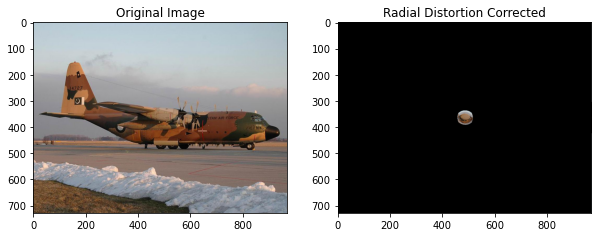

In [16]:
# Use the radial_distortion_correction function with appropriate k1 and k2 values for barrel distortion.
radial_distortion_correction('c130.jpg', 0.0001, 0.00002)  # Example values; adjust based on actual distortion.


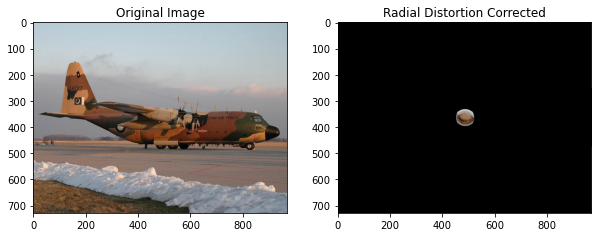

In [17]:
# For fish-eye correction, you might need to adjust the distortion coefficients more significantly.
radial_distortion_correction('c130.jpg', -0.001, 0.00001)  # Example values; adjust based on actual distortion.


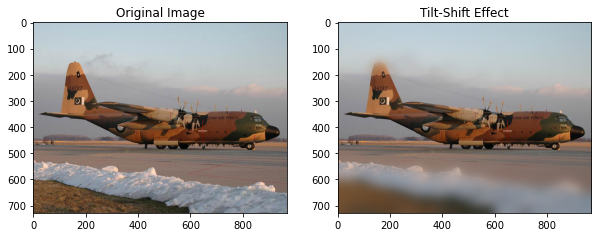

In [18]:
def tilt_shift_effect(image_path):
    # Load the image
    image = cv2.imread(image_path)
    blurred_image = cv2.GaussianBlur(image, (0, 0), 20)
    
    # Create a mask with a gradient for the transition
    mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
    cv2.rectangle(mask, (0, int(image.shape[0]*0.25)), (image.shape[1], int(image.shape[0]*0.75)), (1, 1, 1), -1)
    mask = cv2.GaussianBlur(mask, (0, 0), 30)
    
    # Combine the blurred and original image using the mask
    final_image = blurred_image * (1 - mask) + image * mask
    
    # Display the original and tilt-shift effect images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Tilt-Shift Effect')
    plt.imshow(cv2.cvtColor(final_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()

tilt_shift_effect('c130.jpg')


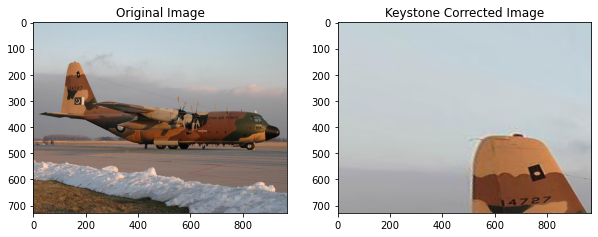

In [19]:
def keystone_correction(image_path, src_points):
    # Load the image
    image = cv2.imread(image_path)
    rows, cols = image.shape[:2]
    
    # Define destination points (corners of the image)
    dst_points = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
    
    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Apply the perspective transformation
    corrected_image = cv2.warpPerspective(image, matrix, (cols, rows))
    
    # Display the original and corrected images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Keystone Corrected Image')
    plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Example source points for keystone correction
src_points = np.float32([[100, 100], [200, 50], [50, 250], [250, 300]])
keystone_correction('c130.jpg', src_points)


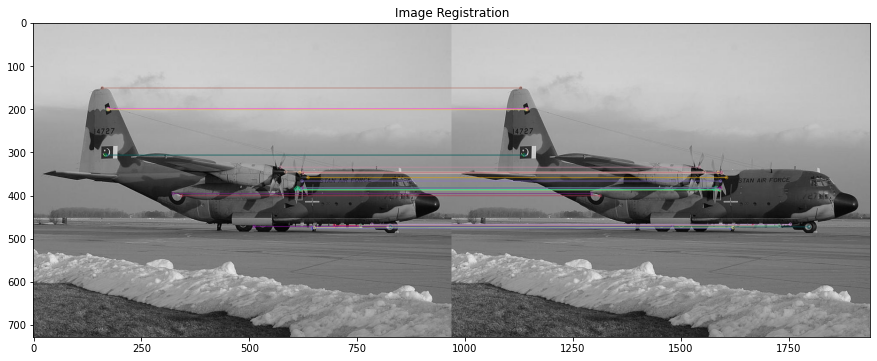

In [21]:
def image_registration(reference_image_path, sensed_image_path):
    # Load the images
    reference_image = cv2.imread(reference_image_path, 0)  # Load as grayscale
    sensed_image = cv2.imread(sensed_image_path, 0)
    
    # Detect ORB features and compute descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(reference_image, None)
    keypoints2, descriptors2 = orb.detectAndCompute(sensed_image, None)
    
    # Match features using KNN
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Draw top N matches
    result_image = cv2.drawMatches(reference_image, keypoints1, sensed_image, keypoints2, matches[:30], None, flags=2)
    
    # Display the matched features
    plt.figure(figsize=(15, 7))
    plt.title('Image Registration')
    plt.imshow(result_image)
    plt.show()

image_registration('c130.jpg', 'c130.jpg')


In [22]:
from scipy.interpolate import Rbf

def local_deformation(image_path, point, target, radius=50):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create a meshgrid for the image coordinates
    x, y = np.meshgrid(range(image_rgb.shape[1]), range(image_rgb.shape[0]))
    
    # Compute the distance of each point in the meshgrid from the target point
    distance = np.sqrt((x - point[0])**2 + (y - point[1])**2)
    
    # Apply a radial basis function to create a displacement field
    rbf = Rbf(distance, function='multiquadric', epsilon=radius)
    displacement = rbf(distance)
    
    # Normalize the displacement field to have a maximum of 1
    displacement /= np.max(displacement)
    
    # Create new indices by adding the displacement to the original indices
    x_new = np.clip(x + displacement * (target[0] - point[0]), 0, image_rgb.shape[1]-1)
    y_new = np.clip(y + displacement * (target[1] - point[1]), 0, image_rgb.shape[0]-1)
    
    # Map the original image onto the new indices
    deformed_image = cv2.remap(image_rgb, x_new.astype(np.float32), y_new.astype(np.float32), cv2.INTER_LINEAR)
    
    # Display the original and deformed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Locally Deformed Image')
    plt.imshow(deformed_image)
    plt.show()

# Example deformation from point to target
local_deformation('c130.jpg', point=[100, 100], target=[150, 150])


ValueError: A 2-dimensional array must be passed.

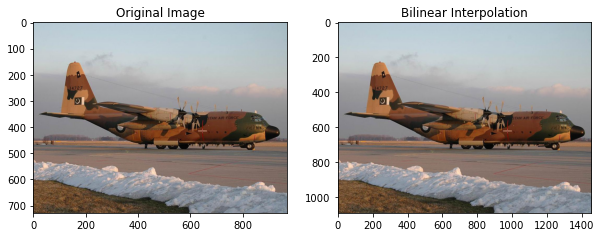

In [23]:
def bilinear_interpolation(image_path, scale_factor):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply bilinear interpolation using OpenCV resize function
    resized_image = cv2.resize(image_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)
    
    # Display the original and resized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Bilinear Interpolation')
    plt.imshow(resized_image)
    plt.show()

bilinear_interpolation('c130.jpg', 1.5)


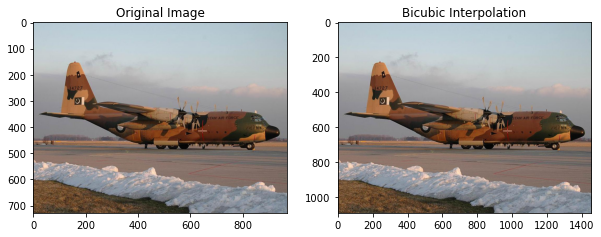

In [24]:
def bicubic_interpolation(image_path, scale_factor):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply bicubic interpolation using OpenCV resize function
    resized_image = cv2.resize(image_rgb, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    
    # Display the original and resized images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_rgb)
    plt.subplot(1, 2, 2)
    plt.title('Bicubic Interpolation')
    plt.imshow(resized_image)
    plt.show()

bicubic_interpolation('c130.jpg', 1.5)
